<a href="https://colab.research.google.com/github/MxMathe/Transfer-Learning/blob/main/Transfer_Learning_Classificador_de_imagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Transfer Learning DataSet tensorflow horses or humans*

In [15]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


Carregando o modelo pré-treinado (ResNet50)

In [2]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


*Carregamento do dataset "horses_or_humans"*

In [3]:
dataset_name = "horses_or_humans"
(data_train, data_test), dataset_info = tfds.load(
    dataset_name,
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/horses_or_humans/incomplete.R6IGCM_3.0.0/horses_or_humans-train.tfrecord*.…

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/horses_or_humans/incomplete.R6IGCM_3.0.0/horses_or_humans-test.tfrecord*..…

Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


*Informações sobre o dataset*

In [4]:
print(f"Classes: {dataset_info.features['label'].num_classes}")
print(f"Descrição: {dataset_info.description}")

Classes: 2
Descrição: A large set of images of horses and humans.


*Pré-processamento das imagens*

In [5]:
IMG_SIZE = (224, 224)

def preprocess_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

train_dataset = data_train.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = data_test.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

*Adicionar camadas customizadas*

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)  # 2 classes: cavalos e humanos

model = Model(inputs=base_model.input, outputs=predictions)

*Congelar camadas do modelo base*

In [7]:
for layer in base_model.layers:
    layer.trainable = False

In [8]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

*Compilação do modelo*

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])


*Treinamento do modelo*

In [10]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=10)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 205s 8s/step - accuracy: 0.9415 - loss: 0.1061 - val_accuracy: 1.0000 - val_loss: 7.6600e-06
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 192s 7s/step - accuracy: 1.0000 - loss: 4.8030e-05 - val_accuracy: 1.0000 - val_loss: 8.9838e-07
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 193s 7s/step - accuracy: 1.0000 - loss: 2.8820e-07 - val_accuracy: 1.0000 - val_loss: 2.8494e-08
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 198s 7s/step - accuracy: 1.0000 - loss: 4.4287e-08 - val_accuracy: 1.0000 - val_loss: 2.3260e-08
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 199s 7s/step - accuracy: 1.0000 - loss: 3.8734e-08 - val_accuracy: 1.0000 - val_loss: 2.2679e-08
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 208s 7s/step - accuracy: 1.0000 - loss: 3.8026e-08 - val_accuracy: 1.0000 - val_loss: 2.2679e-08
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 197s 7s/step - accuracy: 1.0000 - loss: 3.7301e-08 - val_accuracy: 1.0000 - val_loss: 2.2679e-08
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 210s 8s/step - accura

*Libera mais camadas caso o resultado não seja o desejado*

In [11]:
for layer in base_model.layers[-10:]:  # Últimas 10 camadas do modelo base
    layer.trainable = True

*Recompila com taxa menor de apredizado*

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Taxa de aprendizado menor ao treinar mais camadas
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

*Novo treinamento com as novas camadas*

In [13]:
history_finetune = model.fit(train_dataset, validation_data=test_dataset, epochs=5)

Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 228s 8s/step - accuracy: 1.0000 - loss: 2.3268e-07 - val_accuracy: 1.0000 - val_loss: 1.4538e-08
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 261s 8s/step - accuracy: 1.0000 - loss: 1.5881e-08 - val_accuracy: 1.0000 - val_loss: 3.2564e-08
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 215s 8s/step - accuracy: 1.0000 - loss: 7.9770e-09 - val_accuracy: 1.0000 - val_loss: 4.5939e-08
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 261s 8s/step - accuracy: 1.0000 - loss: 6.2834e-09 - val_accuracy: 1.0000 - val_loss: 5.6988e-08
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 261s 8s/step - accuracy: 1.0000 - loss: 4.9202e-09 - val_accuracy: 1.0000 - val_loss: 6.6292e-08


*Avaliar final do modelo*

In [14]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 1.0000 - loss: 8.5134e-08
Test Accuracy: 1.00


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


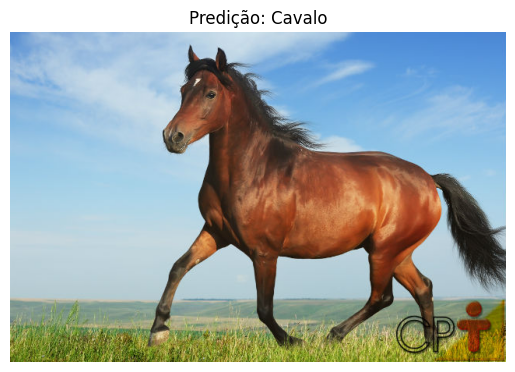

A imagem foi classificada como: Cavalo


In [17]:
def predict_image(img_path, model):
    # Carregar a imagem
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Fazer a predição
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    class_names = ["Cavalo", "Humano"]  # Mapear as classes (ajuste se necessário)

    # Mostrar a imagem e o resultado
    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.title(f"Predição: {class_names[predicted_class]}")
    plt.show()

    return class_names[predicted_class]

# Testar com uma imagem de sua escolha
# Faça o upload da imagem no Colab antes (usando o ícone de upload de arquivos)
uploaded_image_path = "./Imagens_teste/cavalo.jpg"  # Substitua pelo caminho da sua imagem
resultado = predict_image(uploaded_image_path, model)
print(f"A imagem foi classificada como: {resultado}")